>> # ENTRO

 # Breast Cancer Detection using deep learning


 - Breast cancer is the second leading cause of cancer deaths among U.S. women, it is a type of cancer that starts when cells begin to grow out of control
 - Most breast cancers begin in the ducts that  carry milk to the nipple (ductal cancers), 
 - Breast cancer can spread when the cancer cells get into the blood or lymph system and are carried to other parts of the body. 
 - Cancerous breast tumors are detected by a special type of examination, which is screening mammogram

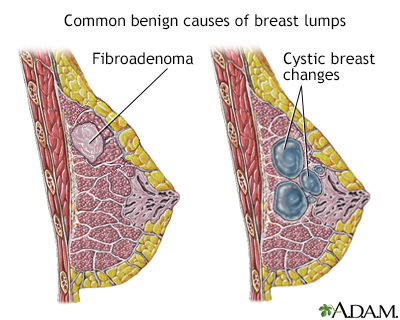

Detection of breast cancer on screening mammography is challenging as an image classification task because the tumors themselves occupy only a small portion of the image of the entire breast. For example, a full-field digital mammography (FFDM) image is typically 4000 × 3000 pixels while a potentially cancerous region of interest (ROI) can be as small as 100 × 100 pixels.



 This explains the large number that we have in the data, which is more than **a quarter of a million** images!

**Our goal:** Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.

>> # CODE

> # Import  Libraries 

In [7]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


> #  Get & Adjust Data

In [8]:
import os

# Updated paths based on "F:\archive"
cancer_rays_dir = os.listdir("F:/archive/IDC_regular_ps50_idx5") 
all_rays_dir = "F:/archive/all_rays_dir"  # Path where all the images will be stored
cancer_rays_dir_str = "F:/archive/IDC_regular_ps50_idx5/"




### what is the structure of our data?

In [9]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

##### We can see 279 files for each patient named with their id, and each file contains x-ray images of its owner

### To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [10]:
all_rays_dir = "F:/archive/all_rays_dir"  # Updated path where all the images will be stored
all_rays_dir_lst = os.listdir(all_rays_dir)

In [11]:
#Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
for patient in cancer_rays_dir:   
    path_0 = cancer_rays_dir_str + str(patient) + '/0'
    path_1 = cancer_rays_dir_str + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [12]:
all_rays_dir = "F:/archive/all_rays_dir"  # Updated path where all the images will be stored

# Updated part to list contents of "F:\archive\all_rays_dir"
all_rays_dir_lst = os.listdir(all_rays_dir)

# Example usage
print("Number of files in all_rays_dir:", len(all_rays_dir_lst))

Number of files in all_rays_dir: 277524


##### Now we have 277,524 images, what a number!

### Then, it's time to put images in a data_frame for easy access:

In [13]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()


image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [14]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [15]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0  10253_idx5_x1001_y1001_class0.png      0      10253
1  10253_idx5_x1001_y1051_class0.png      0      10253
2  10253_idx5_x1001_y1101_class0.png      0      10253
3  10253_idx5_x1001_y1151_class0.png      0      10253
4  10253_idx5_x1001_y1201_class0.png      0      10253

In [16]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

#### It also seems that the number of healthy rays is greater than the number of infected rays, good news!

> # Exploratory Data Analysis

#### First of all, let's take a look at the nature of the mammograms...

## Healthy patches:


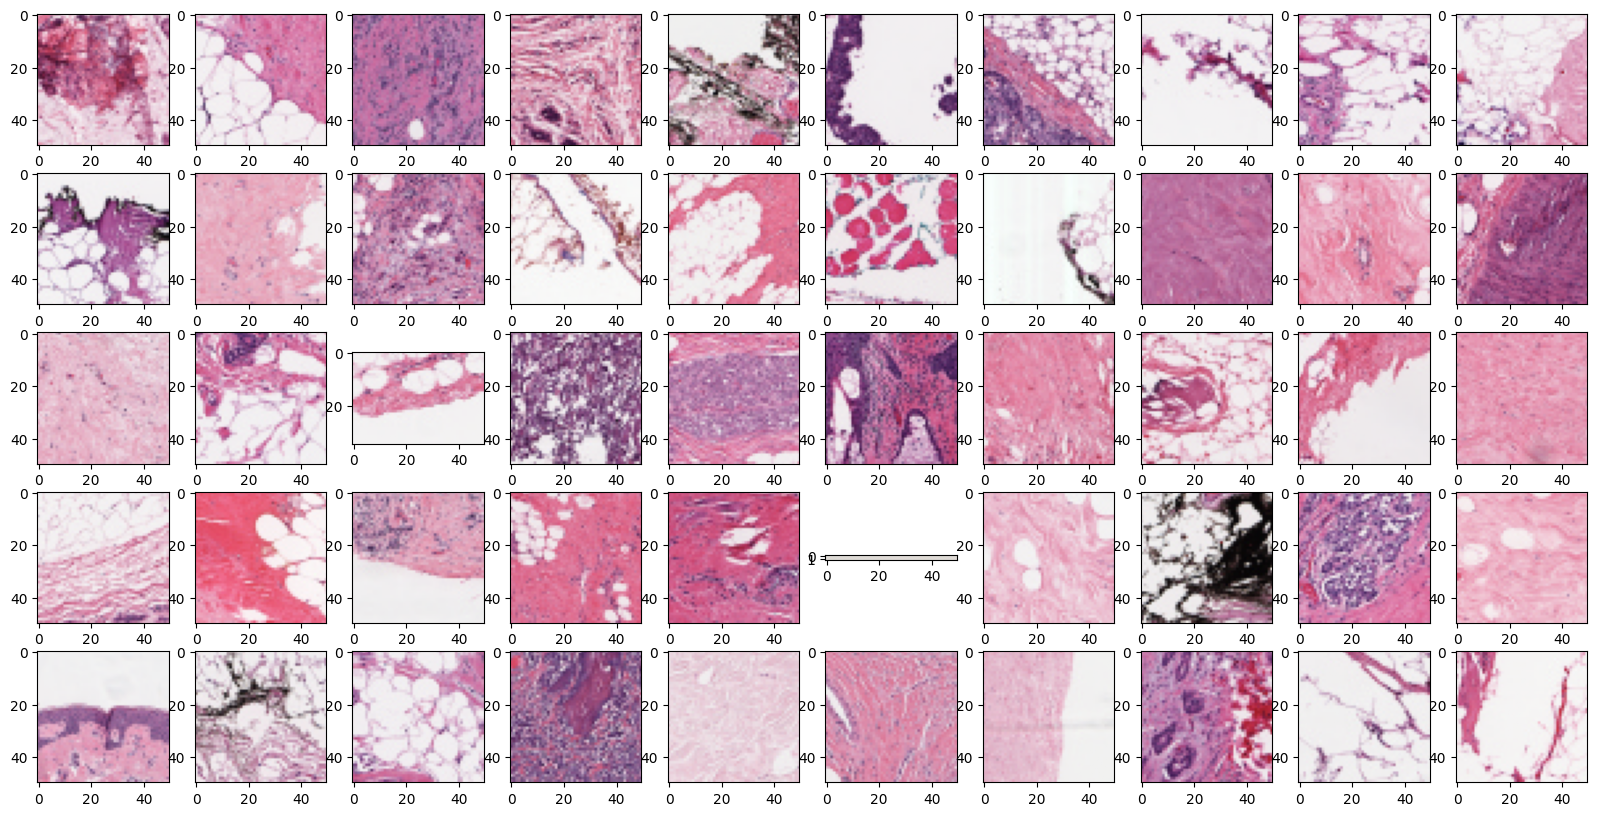

In [17]:
data.target = data.target.astype(np.int64)

fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




### Insights
- Most of the mammograms are light pink, but there are some dark ones too

# Cancer patches:

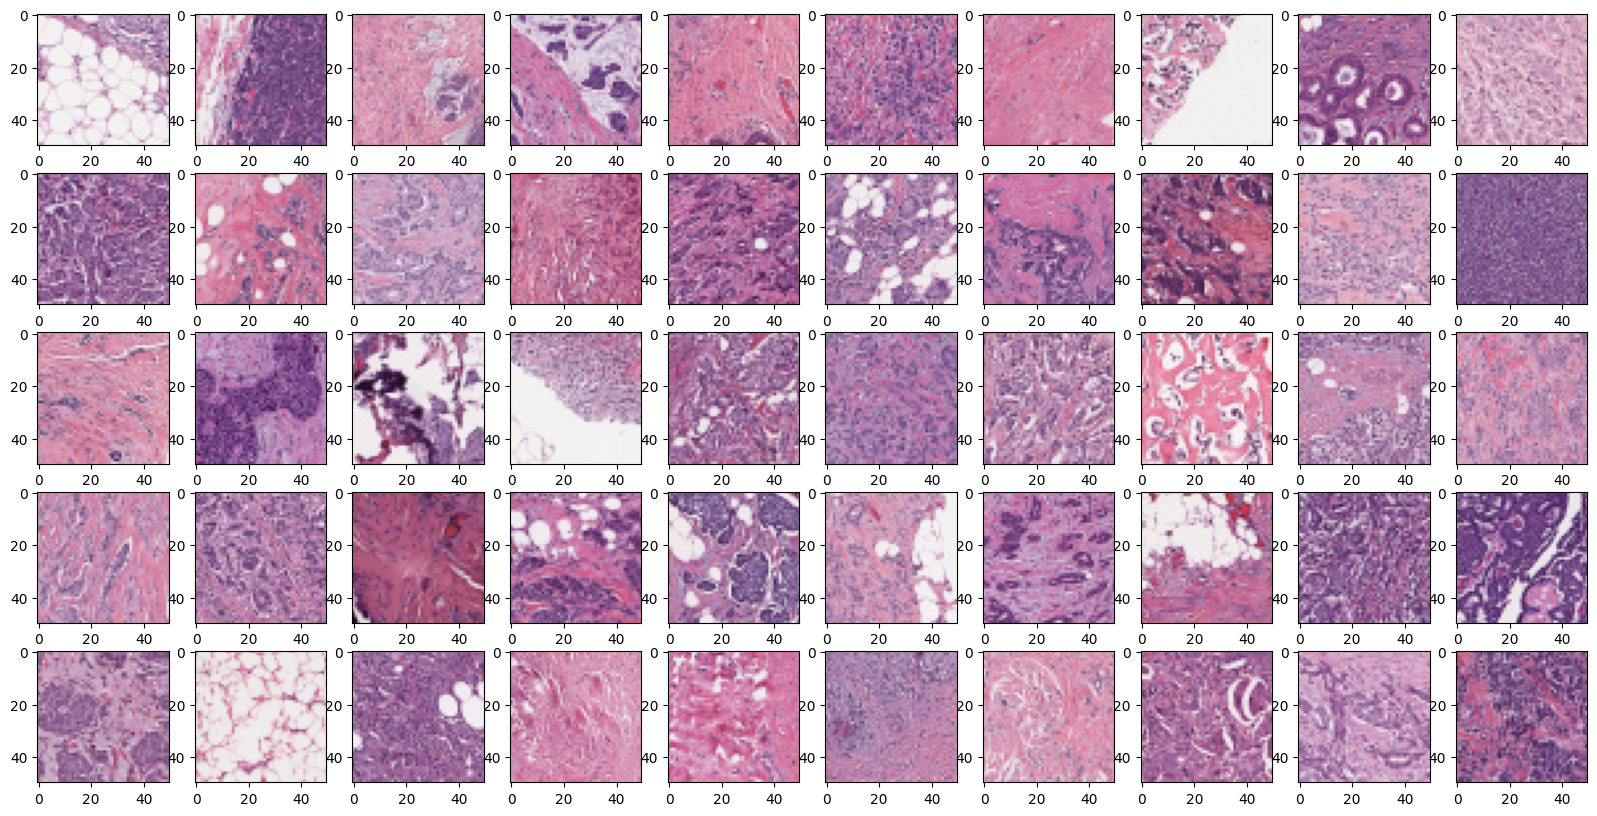

In [18]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Insights

- Patches with cancer look more violet and crowded than healthy ones. 
- In fact, we could not determine the actual difference between the two types with the naked eye, but I think that the model is able to detect hidden patterns in these images that enable us to determine the state of each image.

### Let's ask some questions that will help us get to know more our data:
- do all patients have the same number of mammograms?
- what is the percentage of cancer (IDC) that each mammogram shows? 
- how many healthy and cancered mammograms are in the data?

C:\Users\PS BAHRIA\AppData\Local\Temp\ipykernel_17524\1879669897.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
C:\Users\PS BAHRIA\AppData\Local\Temp\ipykernel_17524\1879669897.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

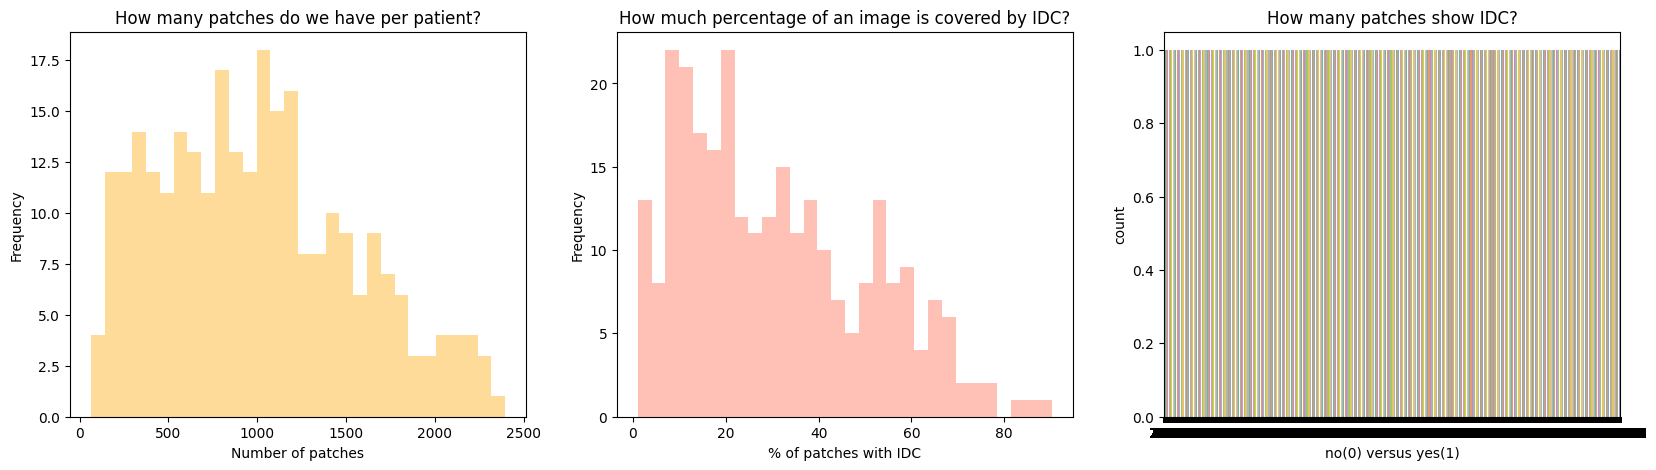

In [19]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights:
- The number of image patches per patient varies a lot
- Most of the photos have a percentage that is not large, but there are other photos that have a percentage of up to 80%
- the smaller number of mammograms had cancer

In [20]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int64)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int64)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int64(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int64)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int64)
    return dataframe
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1]) 
    return patient_df

In [21]:

example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  F:/archive/IDC_regular_ps50_idx5/10253/0/10253...
1  1001  1051       0  F:/archive/IDC_regular_ps50_idx5/10253/0/10253...
2  1001  1101       0  F:/archive/IDC_regular_ps50_idx5/10253/0/10253...
3  1001  1151       0  F:/archive/IDC_regular_ps50_idx5/10253/0/10253...
4  1001  1201       0  F:/archive/IDC_regular_ps50_idx5/10253/0/10253...

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

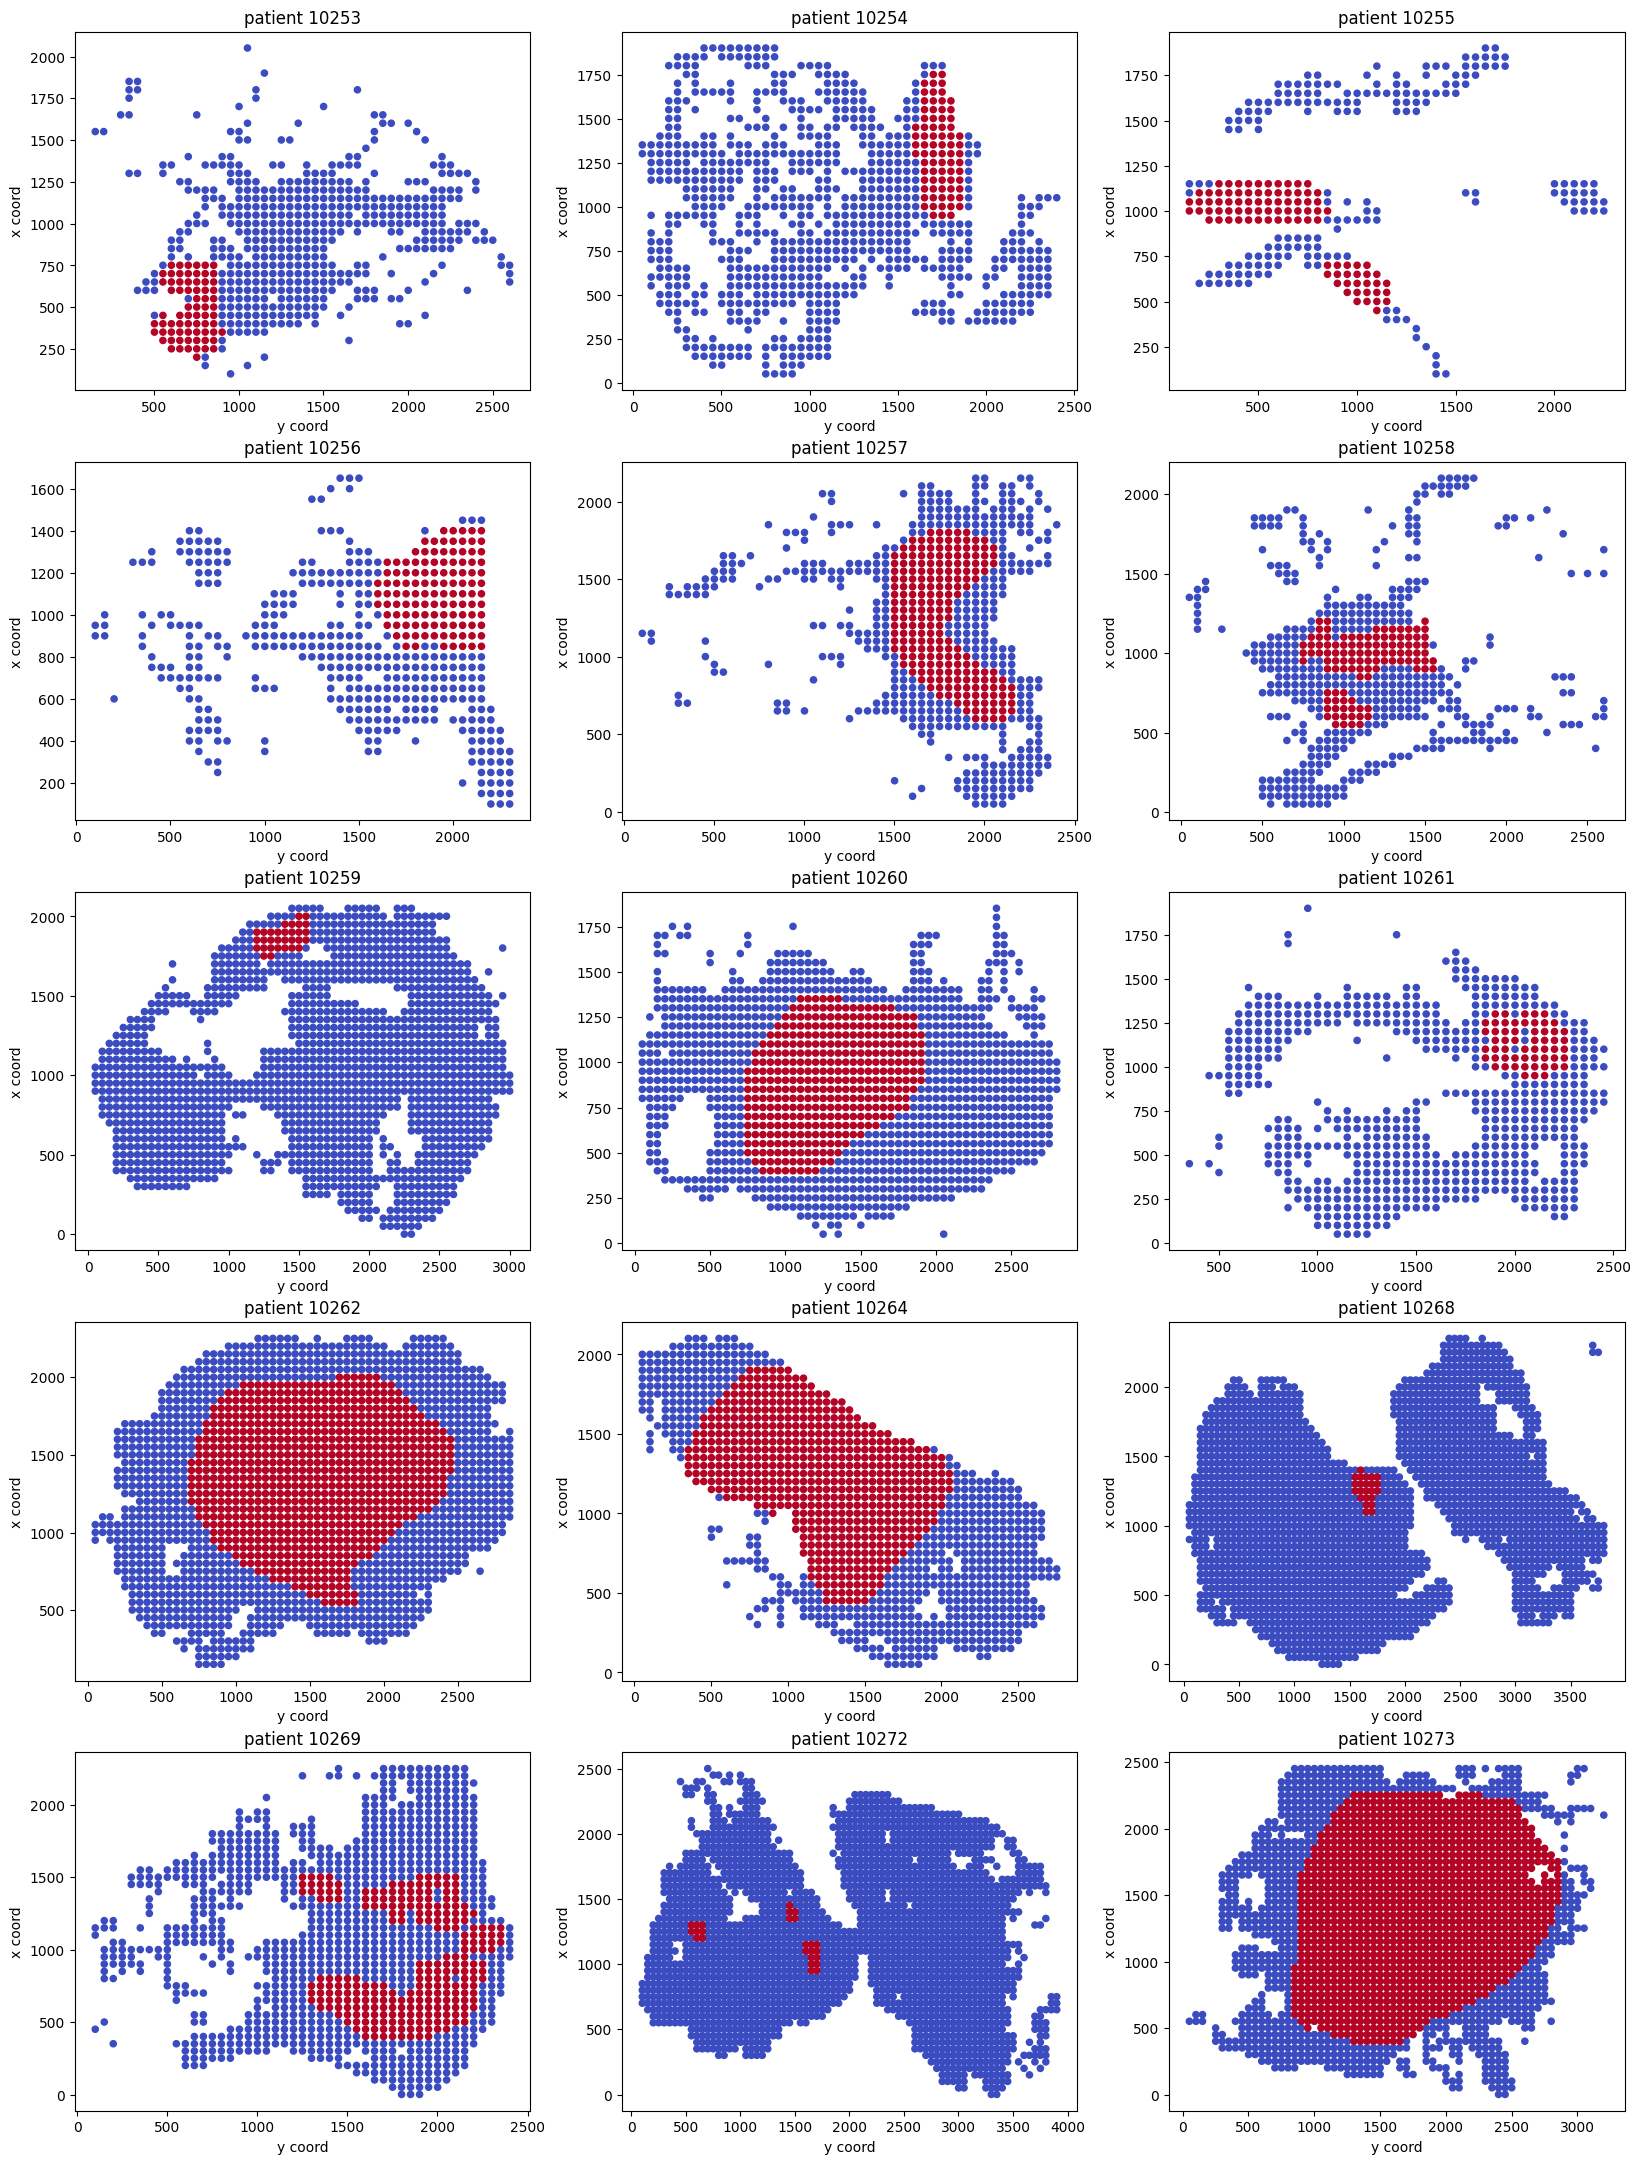

In [22]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights:

- We see a large variation in the concentration of cells
- Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

> # Processing and selection
it's time to work on our data..

# Image Processing 

-  Apply some processing properties

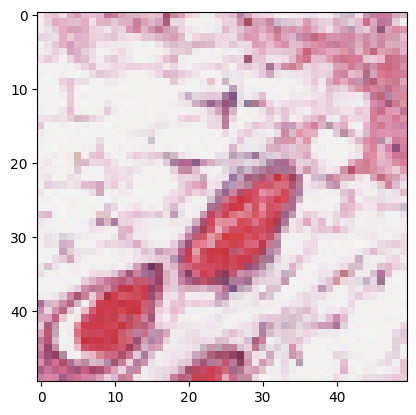

In [24]:
data.target = data.target.astype(np.int64)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

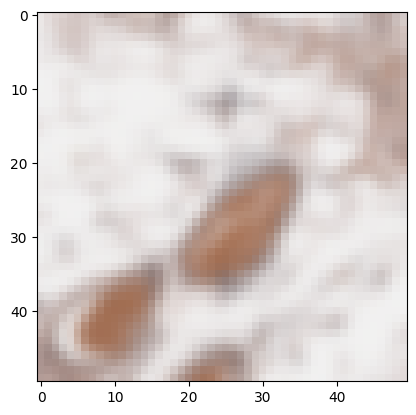

In [25]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

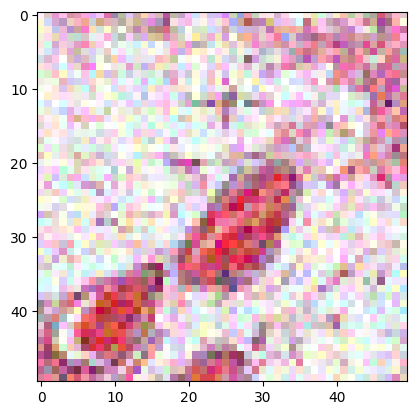

In [26]:
noise_image = random_noise(image)
plt.imshow(noise_image)

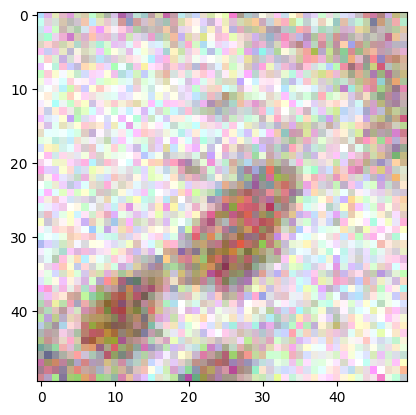

In [27]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

-  Processing using (random_noise) function

In [28]:
os.mkdir('image_processing') #We create a new file to process the data in
os.mkdir('image_processing/noise_images')

In [29]:
#Here we take the image from the normal images folder, process it, and then save it in the new file
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)
    

In [30]:
os.mkdir( 'image_processing/processd_data_train')
os.mkdir( 'image_processing/processd_data_test')
os.mkdir( 'image_processing/processd_data_train/zeros')
os.mkdir( 'image_processing/processd_data_train/ones')
os.mkdir( 'image_processing/processd_data_test/zeros')
os.mkdir( 'image_processing/processd_data_test/ones')


In [31]:

processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [32]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [33]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [34]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [35]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)


In [36]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [37]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


# Processing  and Normal test

-  the images we processed and the noraml are tested on the same model to see which the best in the accuracy

-  A small sample is taken for testing (20,000) images

### First: the processed images

In [38]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [39]:
os.mkdir( 'image_processing/model_tst')
os.mkdir( 'image_processing/model_tst/trainig')
os.mkdir( 'image_processing/model_tst/testing')          
os.mkdir( 'image_processing/model_tst/trainig/zeros')
os.mkdir( 'image_processing/model_tst/trainig/ones')
os.mkdir( 'image_processing/model_tst/testing/zeros')
os.mkdir( 'image_processing/model_tst/testing/ones')

In [40]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


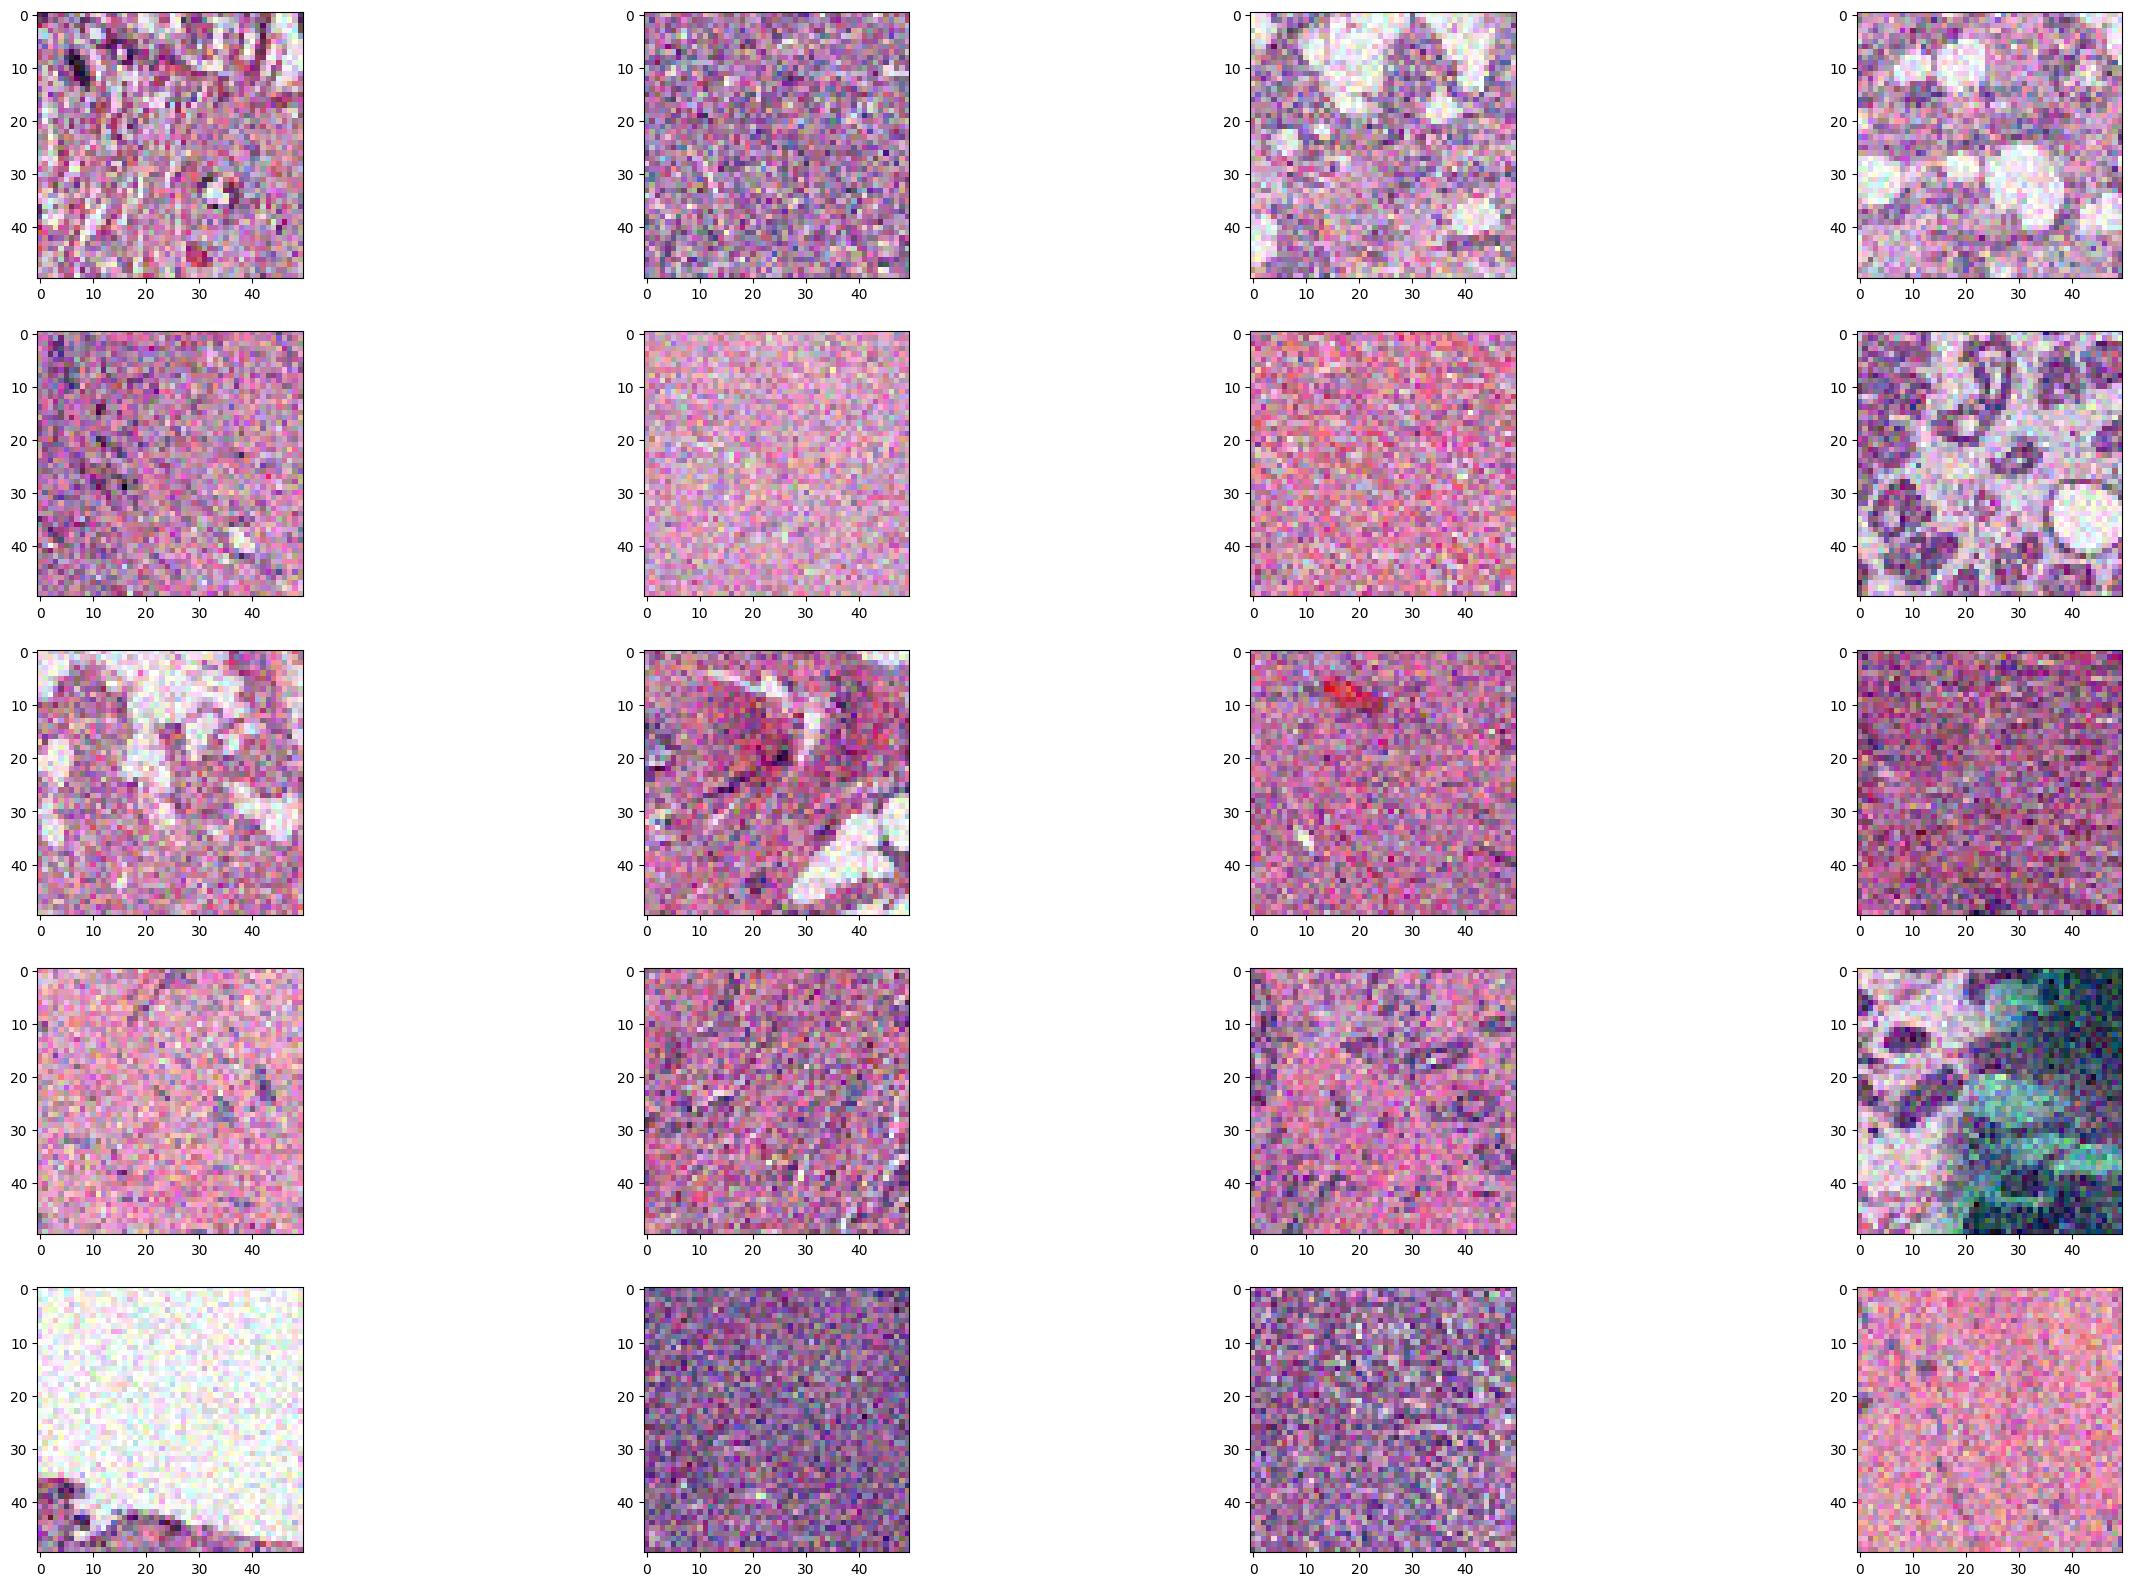

In [41]:
processd_data.target = processd_data.target.astype(np.int64)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the processed carcinogenic images

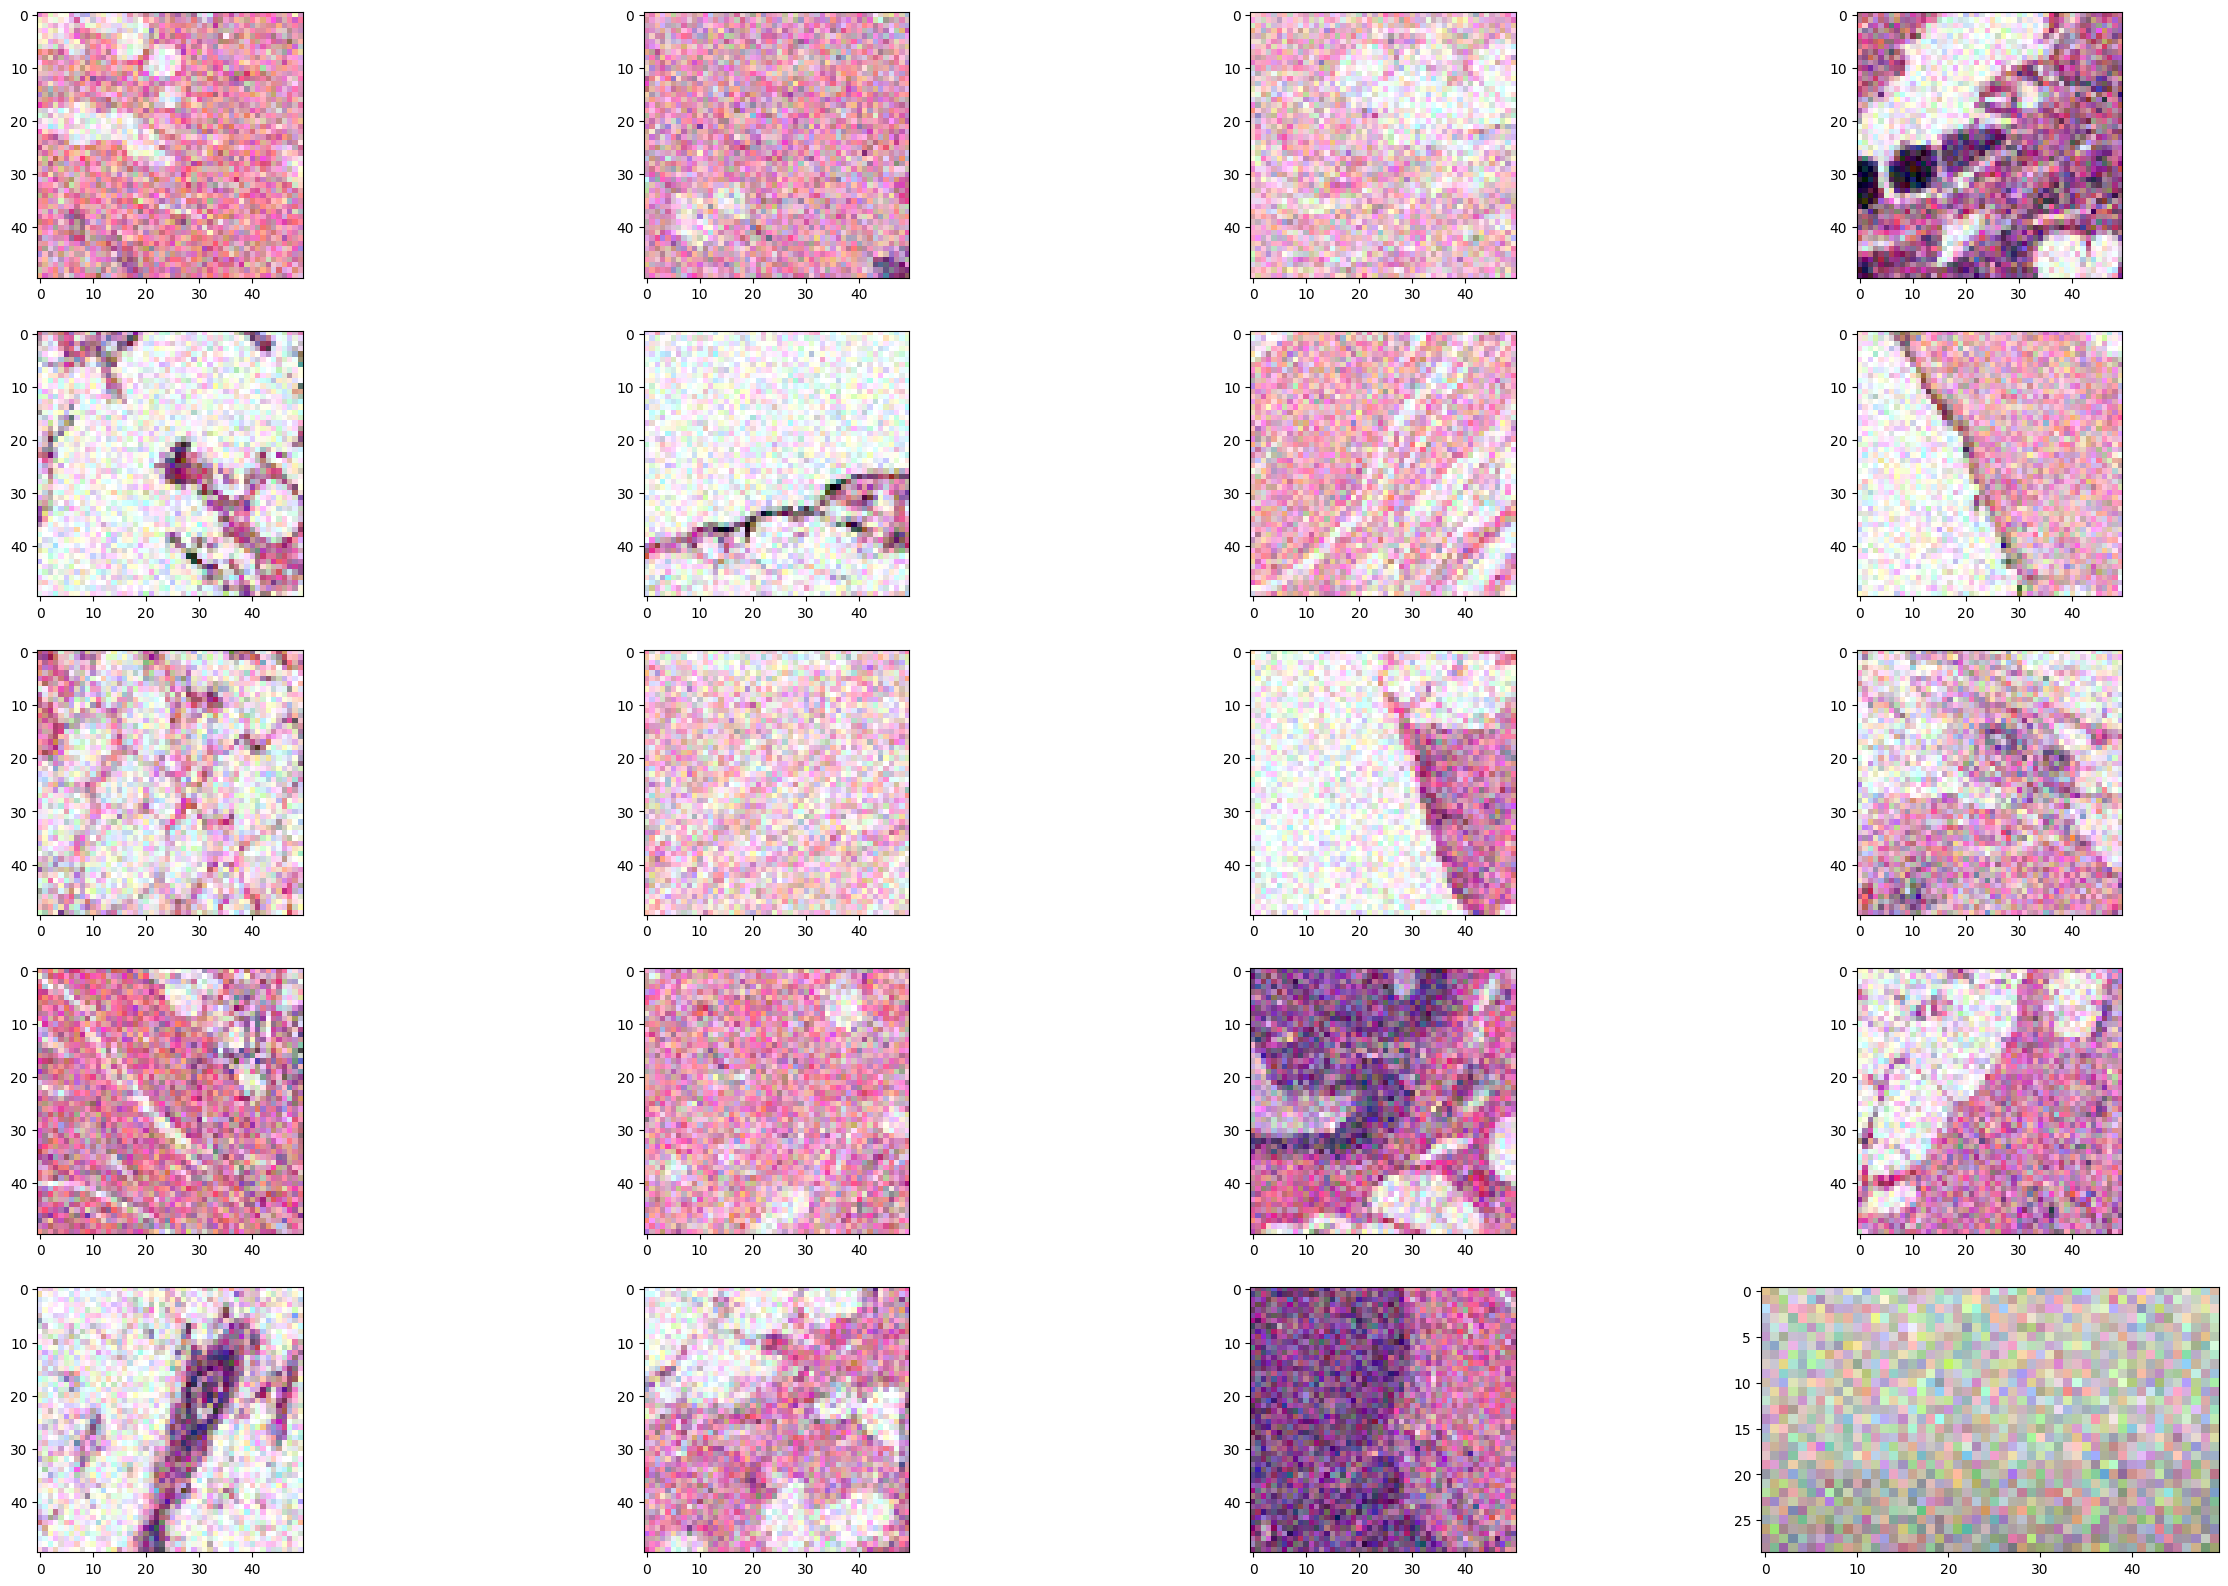

In [42]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the normal images that have been processed

In [43]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [100]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [46]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_processd, validation_data=test_generation_processd, epochs=60, verbose=1, callbacks=[early_stop])


Epoch 1/60


C:\Users\PS BAHRIA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 244s 134ms/step - accuracy: 0.6998 - loss: 0.5939 - val_accuracy: 0.7855 - val_loss: 0.4681
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 99s 55ms/step - accuracy: 0.7802 - loss: 0.4838 - val_accuracy: 0.7965 - val_loss: 0.4603
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 100s 56ms/step - accuracy: 0.7918 - loss: 0.4615 - val_accuracy: 0.7070 - val_loss: 0.5962
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 100s 56ms/step - accuracy: 0.7920 - loss: 0.4621 - val_accuracy: 0.8005 - val_loss: 0.4507
Epoch 5/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 99s 55ms/step - accuracy: 0.7955 - loss: 0.4532 - val_accuracy: 0.7940 - val_loss: 0.4482
Epoch 6/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 101s 56ms/step - accuracy: 0.8052 - loss: 0.4360 - val_accuracy: 0.8070 - val_loss: 0.4550
Epoch 7/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 103s 57ms/step - accuracy: 0.8080 - loss: 0.4336 - val_accuracy: 0.7805 - val_loss: 0.4712


### Second: the normal images

In [47]:
os.mkdir( 'image_processing/normal')
os.mkdir( 'image_processing/normal/model_tst') 
os.mkdir( 'image_processing/normal/model_tst/trainig')
os.mkdir( 'image_processing/normal/model_tst/testing')
os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [48]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


In [49]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [96]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [51]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


C:\Users\PS BAHRIA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 228s 126ms/step - accuracy: 0.8113 - loss: 0.4237 - val_accuracy: 0.8040 - val_loss: 0.4532
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - accuracy: 0.8188 - loss: 0.4103 - val_accuracy: 0.8025 - val_loss: 0.4512
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 91s 50ms/step - accuracy: 0.8231 - loss: 0.3967 - val_accuracy: 0.7865 - val_loss: 0.4621
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step - accuracy: 0.8301 - loss: 0.3797 - val_accuracy: 0.7955 - val_loss: 0.4513


## conclusion : Normal images are the best in modeling 

> # Modeling

# Data Spliting & Generation

In [52]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0

In [53]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [54]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [55]:
os.mkdir( 'train_dir')
os.mkdir('test_dir')

In [56]:
os.mkdir( 'train_dir/zeros')
os.mkdir( 'train_dir/ones')

os.mkdir( 'test_dir/zeros')
os.mkdir( 'test_dir/ones')


In [57]:
train = data_train.image_id
test  = data_test.image_id

In [58]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [59]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)


In [60]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [61]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [62]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


># Model design

In [63]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

C:\Users\PS BAHRIA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
my_model.fit(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


C:\Users\PS BAHRIA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24978/24978 ━━━━━━━━━━━━━━━━━━━━ 3031s 121ms/step - accuracy: 0.8085 - loss: 0.4343 - val_accuracy: 0.8434 - val_loss: 0.3623
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 2378s 95ms/step - accuracy: 0.8351 - loss: 0.3837 - val_accuracy: 0.8386 - val_loss: 0.3713
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 2691s 108ms/step - accuracy: 0.8435 - loss: 0.3661 - val_accuracy: 0.8533 - val_loss: 0.3484
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 2589s 104ms/step - accuracy: 0.8487 - loss: 0.3550 - val_accuracy: 0.8286 - val_loss: 0.3952
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 2738s 110ms/step - accuracy: 0.8339 - loss: 0.3916 - val_accuracy: 0.8104 - val_loss: 0.4229


># Outputs and Outcomes

In [66]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0  0.821909  0.409872      0.843404  0.362345
1  0.837019  0.379136      0.838648  0.371285
2  0.844838  0.362875      0.853349  0.348427
3  0.842484  0.368243      0.828631  0.395195
4  0.833712  0.391152      0.810363  0.422908

<Axes: >

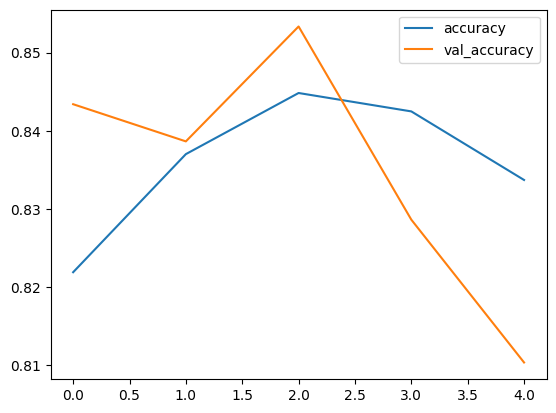

In [67]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

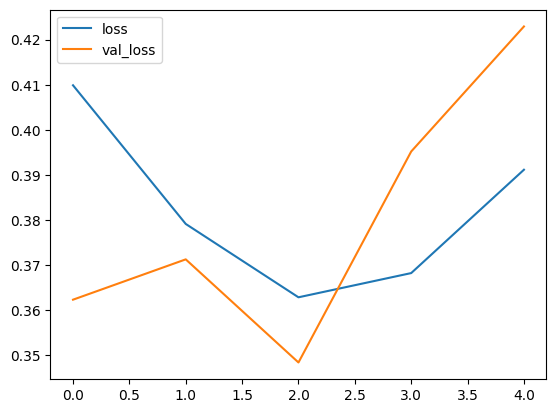

In [68]:
losse[['loss','val_loss']].plot()


In [70]:
val_loss, val_acc = \
my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 250s 90ms/step - accuracy: 0.8081 - loss: 0.4282
val_loss: 0.4229077994823456
val_acc: 0.8103628158569336


## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 85%
- over fitting is so small 
- We're ready to create APIs

> # Save &Loaded Model

In [71]:
model_json = my_model.to_json()

In [73]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [75]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


In [79]:
# Save the entire model
my_model.save("model.h5")
print("Saved model to disk")



Saved model to disk


In [81]:
import tensorflow as tf

# Load the entire model
loaded_model = tf.keras.models.load_model("model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


> # APIs &  Web Localization

- we will use this class to connect the web app to the model

In [132]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class Api_service:
    def __init__(self, img_dir, model_path):
        self.img_dir = img_dir
        self.model_path = model_path
        self.model = load_model(model_path)
        self.image_size = (25, 25)  # Adjust based on your model's input size
        print("Model loaded successfully.")

    def prediction_function(self, file_path):
        try:
            # Load and preprocess the image
            img = load_img(file_path, target_size=self.image_size)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalize the image

            # Make prediction
            prediction = self.model.predict(img_array)
            cancer_probability = prediction[0][1]  # Assuming index 1 corresponds to cancer

            # Determine the result based on the probability
            if cancer_probability >= 0.5:
                result = "Cancer detected"
            else:
                result = "No cancer detected"

            return result
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None

# Example usage as a standalone script
if __name__ == "__main__":
    img_dir = "G:/Downloads/test_dir"
    model_path = "G:/Downloads/model.h5"
    file_path = "F:/archive/8864/1/8864_idx5_x1451_y2651_class1.png" # Replace with an actual image file in the test directory
    prediction_service = Api_service(img_dir, model_path)
    result = prediction_service.prediction_function(file_path)
    if result:
        print(result)


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Cancer detected


#  *Finally we have finished*

-from [https://github.com/Ziad-o-Yusef/breast-cancer-detection-using-cnn-DL-] You can view the project in GitHub as well as web application files 
